# Setup

In [89]:
import ugradio
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import lstsq, inv, norm
from scipy.fft import fft, ifft, fftfreq, fftshift, ifftshift
from scipy.stats import norm, linregress
from scipy.optimize import curve_fit, least_squares
from scipy.signal import find_peaks, stft
from scipy.special import j1
from uncertainties import ufloat
from dataclasses import dataclass
from typing import Dict, Optional, Tuple
import os
import glob
import time
import pandas as pd
import datetime
from astropy.time import Time
from astropy.coordinates import EarthLocation
import astropy.units as u
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

In [90]:
# Consistent Plot Params
titleSize = 15
axisSize = 15
legendSize = 13
graphSizeSingle = (8, 6)
graphSizeDouble = (15, 6)
graphSizeHorizontal = (20, 6)

# Data Extraction & Cleansing

In [91]:
def extractSdrCalData(sdr_0_paths, sdr_0_cal_paths, sdr_1_paths, sdr_1_cal_paths, normalize=True, pickling=False):
    prefix = "ugastro\\Lab4Data\\"
    sdr_data, cal_data = [[], []], [[], []]
    if normalize:
        for path_0, path_1 in zip(sdr_0_paths, sdr_1_paths):
            sdr_data[0].append(subtractMean(np.load(prefix+path_0, allow_pickle=pickling)))
            sdr_data[1].append(subtractMean(np.load(prefix+path_1, allow_pickle=pickling)))

        for path_0, path_1 in zip(sdr_0_cal_paths, sdr_1_cal_paths):
            cal_data[0].append(subtractMean(np.load(prefix+path_0, allow_pickle=pickling)))
            cal_data[1].append(subtractMean(np.load(prefix+path_1, allow_pickle=pickling)))
    else:
        for path_0, path_1 in zip(sdr_0_paths, sdr_1_paths):
            sdr_data[0].append(np.load(prefix+path_0, allow_pickle=pickling))
            sdr_data[1].append(np.load(prefix+path_1, allow_pickle=pickling))

        for path_0, path_1 in zip(sdr_0_cal_paths, sdr_1_cal_paths):
            cal_data[0].append(np.load(prefix+path_0, allow_pickle=pickling))
            cal_data[1].append(np.load(prefix+path_1, allow_pickle=pickling))
    return sdr_data, cal_data

def extractSdrData(sdr_0_paths, sdr_1_paths, normalize=False, pickling=False):
    prefix = "ugastro\\Lab4Data\\"
    sdr_data = [[], []]
    if normalize:
        for path_0, path_1 in zip(sdr_0_paths, sdr_1_paths):
            sdr_data[0].append(subtractMean(np.load(prefix+path_0, allow_pickle=pickling)))
            sdr_data[1].append(subtractMean(np.load(prefix+path_1, allow_pickle=pickling)))
    else:
        for path_0, path_1 in zip(sdr_0_paths, sdr_1_paths):
            sdr_data[0].append(np.load(prefix+path_0, allow_pickle=pickling))
            sdr_data[1].append(np.load(prefix+path_1, allow_pickle=pickling))
    return sdr_data

def subtractMean(data):
    return data - np.mean(data)

In [92]:
@dataclass
class PointData:
    id: int
    l: float
    b: float
    ra: float
    dec: float
    LSB: Optional[np.ndarray] = None
    USB: Optional[np.ndarray] = None
    is_calibration: bool = False
    timestamp: str = ""

def extractSdrPoints(base_path, normalize=False, correction="") -> Dict[int, Dict[int, PointData]]:
    # Dictionary of two SDRs (device_index 0 & 1)
    data = {
        0: {"normal": [], "calibration": []},
        1: {"normal": [], "calibration": []}
    }

    prefix = "ugastro\\Lab4Data\\"
    for sdr_index in [0, 1]:
        pol_folder = os.path.join(prefix+base_path, f"pol{sdr_index}")
        if not os.path.isdir(pol_folder):
            print(f"Warning: Folder {pol_folder} not found.")
            continue

        for fname in os.listdir(pol_folder):
            if fname.endswith(".npz") and fname.startswith("obs_"):
                # Parse the filename: obs_{point_id}_{mode}.npz
                parts = fname.replace(correction+".npz", "").split("_")
                try:
                    point_id = int(parts[1])
                    mode = "_".join(parts[2:])  # "LSB" or "USB"
                except (IndexError, ValueError):
                    print(f"Skipping unrecognized file: {fname}")
                    continue

                file_path = os.path.join(pol_folder, fname)
                try:
                    with np.load(file_path) as npzfile:    
                        spectrum = npzfile['spectrum']
                        if normalize:
                            spectrum = spectrum / np.max(spectrum)

                        point = PointData(
                            id=point_id,
                            l=npzfile["gal_l"].item(),
                            b=npzfile["gal_b"].item(),
                            ra=npzfile["ra"].item(),
                            dec=npzfile["dec"].item(),
                            is_calibration=bool(npzfile["is_calibration"].item()),
                            timestamp=str(npzfile["timestamp"])
                        )

                        if mode == "LSB":
                            point.LSB = spectrum
                            point.USB = None
                            point.is_calibration = False
                        elif mode == "USB":
                            point.USB = spectrum
                            point.LSB = None
                            point.is_calibration = False
                        elif mode == "cal_on":
                            point.USB = spectrum
                            point.is_calibration = True
                        else:
                            print(f"Unknown mode: {mode} in file {fname}")

                        if mode not in ("USB", "LSB"):
                            data[sdr_index]["calibration"].append(point)
                        else:
                            data[sdr_index]["normal"].append(point)
                            
                except Exception as e:
                    print(f"{file_path} Error: {e}")
                    continue
    return data

folder_path = "4_25_1"
correction = ".npy"
data_4_25 = extractSdrPoints(folder_path, correction=correction)

In [93]:
print(len(data_4_25[0]['normal']))
print(len(data_4_25[0]["calibration"]))
data_4_25[0]["calibration"]

for p in data_4_25[0]["calibration"]:
    p.USB += 10

30
12


In [94]:
LO_USB = 1420e6
LO_LSB = 1420.81150357e6
LINE_FREQ = 1420.405752e6
B = 12e6
SAMPLE_RATE = 2.2e6
WINDOW = 2048
bounds = (5, -5)
c = 299792458

# Power Spectrum Plotting

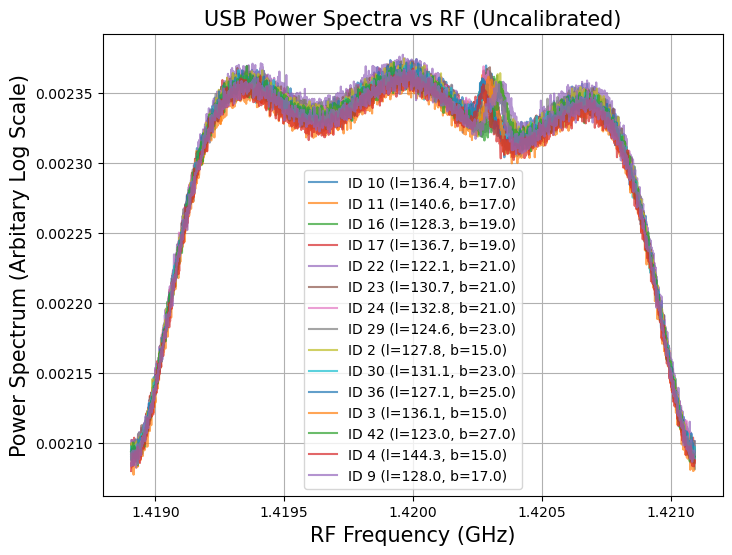

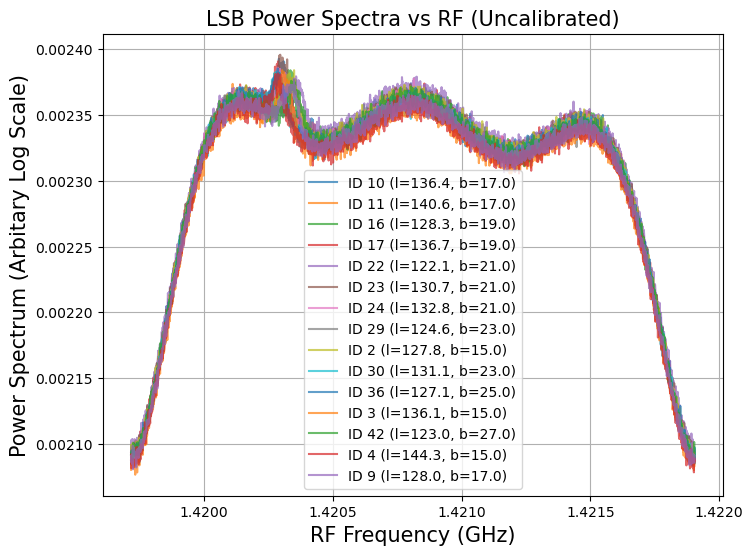

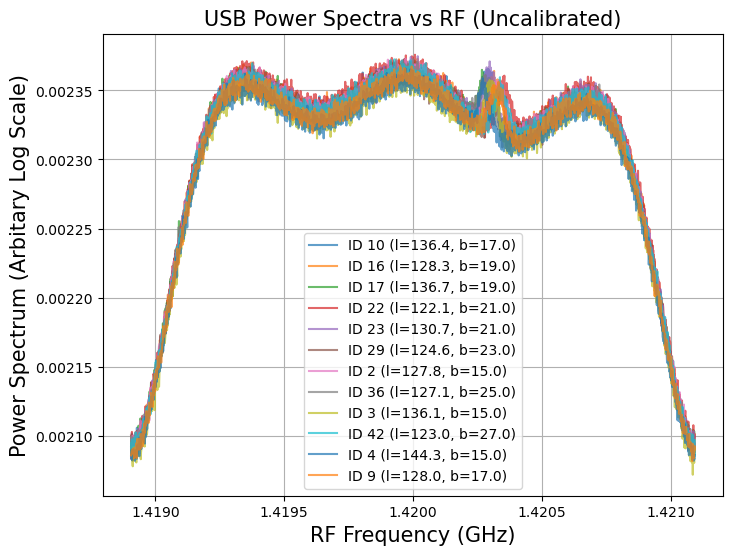

In [95]:
def plot_power_spectra(points, which="USB", LO=LO_USB, spike_mask_range=None, normalize=False, xlim=None, ylim=None, title_extra=""):
    plt.figure(figsize=graphSizeSingle)

    freqs = fftfreq(WINDOW, 1/SAMPLE_RATE) + LO
    freqs = fftshift((freqs))[bounds[0]:bounds[1]]
    
    for point in points:
        spectrum = getattr(point, which)
        if spectrum is None:
            continue    # Skip

        spectrum = spectrum - np.mean(spectrum) if normalize else spectrum
        spectrum = fftshift(np.log(spectrum[bounds[0]:bounds[1]]))
        if spike_mask_range:
            spectrum = mask_and_resample_spike(freqs, spectrum, spike_mask_range)

        label = f"ID {point.id} (l={point.l:.1f}, b={point.b:.1f})"
        plt.plot(freqs / 1e9, spectrum / 4e3, label=label, alpha=0.7)

    plt.xlabel("RF Frequency (GHz)", fontsize=axisSize)
    plt.ylabel("Power Spectrum (Arbitary Log Scale)", fontsize=axisSize)
    #plt.yscale("log")
    plt.xlim(xlim)
    plt.ylim(ylim)
    #plt.legend(fontsize=legendSize)
    plt.legend()
    title_label = "(Normalized)" if normalize else "(Uncalibrated)"
    plt.title(f"{which} Power Spectra vs RF {title_label}", size=titleSize)
    plt.grid()
    plt.show()

def mask_and_resample_spike(freqs, spectrum, spike_range):
    low, high = spike_range
    center_freq = (low + high) / 2
    
    mask_left = (freqs >= low) & (freqs < center_freq)
    mask_right = (freqs >= center_freq) & (freqs <= high)

    # Find nearest neighbors outside the mask
    idx_left = np.where(freqs < low)[0]
    idx_right = np.where(freqs > high)[0]

    if len(idx_left) > 0:
        val_left = spectrum[idx_left[-1]]  # last good point before spike
    else:
        val_left = spectrum[0]

    if len(idx_right) > 0:
        val_right = spectrum[idx_right[0]]  # first good point after spike
    else:
        val_right = spectrum[-1]

    cleaned = np.copy(spectrum)
    cleaned[mask_left] = val_left
    cleaned[mask_right] = val_right

    return cleaned

mask = (1.419995e9, 1.420005e9)
plot_power_spectra(data_4_25[0]["normal"], which="USB", LO=LO_USB)
plot_power_spectra(data_4_25[0]["normal"], which="LSB", LO=LO_LSB, spike_mask_range=mask)
plot_power_spectra(data_4_25[0]["calibration"], which="USB", LO=LO_USB)



# Line Shape, Gain, Calibration

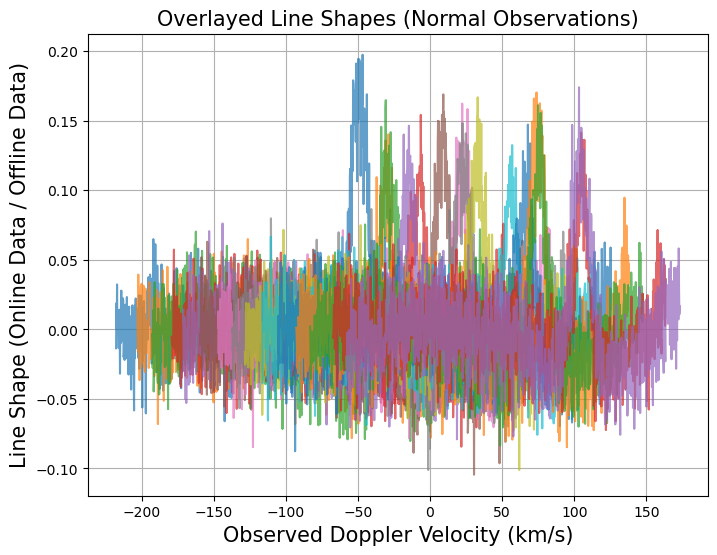

[-13082.346762762127, -14720.60988816956, -10204.15457263215, -13603.388273362974, -8103.411511315806, -11591.122292338034, -12445.100225377206, -9508.463020592864, -9152.598375675698, -12113.41428597213, -10904.196765623616, -12560.02811501613, -9673.146947780384, -15790.386427124318, -9678.436227639848]


In [100]:
lat, lon = ugradio.leo.lat, ugradio.leo.lon
alt = ugradio.leo.alt

def timestampToJD(timestamp):
    t = Time(timestamp, format='isot', scale='utc')  # ISO-8601 format with UTC
    return t.jd

def onlineOfflineSpectra(points, normalize=False, spike_range=None) -> Dict[Tuple[float, float], Dict[str, np.ndarray]]:
    temp_storage: Dict[Tuple[float, float], Dict[str, np.ndarray]] = {}
    freqs = fftfreq(WINDOW, 1/SAMPLE_RATE) + LO_LSB
    freqs_lsb = fftshift((freqs))

    for point in points:
        key = (round(point.l, 3), round(point.b, 3))
        if key not in temp_storage:
            temp_storage[key] = {"USB": None, "LSB": None, "ra": None, "dec": None, "timestamp": None}

        if point.USB is not None:
            temp_storage[key]["USB"] = point.USB
        if point.LSB is not None:
            temp_storage[key]["LSB"] = point.LSB

        temp_storage[key]["ra"] = point.ra
        temp_storage[key]["dec"] = point.dec
        temp_storage[key]["timestamp"] = point.timestamp

    result: Dict[Tuple[float, float], Dict[str, np.ndarray]] = {}

    for (l, b), spectra in temp_storage.items():
        usb = spectra["USB"]
        lsb = spectra["LSB"]
        ra = spectra["ra"]
        dec = spectra["dec"]
        timestamp = spectra["timestamp"]

        if usb is None or lsb is None:
            # skip incomplete points
            continue

        if normalize:
            usb = usb / np.max(usb)
            lsb = lsb / np.max(lsb)

        if spike_range:
            lsb = mask_and_resample_spike(freqs_lsb, lsb, spike_range)

        mid = len(usb) // 2
        online, offline = np.zeros(len(usb)), np.zeros(len(usb))
        #online[:mid], offline[:mid] = lsb[:mid], usb[:mid]
        #online[mid:], offline[mid:] = usb[mid:], lsb[mid:]
        online[mid:], offline[mid:] = lsb[mid:], usb[mid:]
        online[:mid], offline[:mid] = usb[:mid], lsb[:mid]

        line_shape = online / offline
        jd = timestampToJD(timestamp)

        result[(l, b)] = {
            "online": online,
            "offline": offline,
            "line_shape": line_shape,
            "ra": ra,
            "dec": dec,
            "jd": jd
        }

    return result

def plot_lineshapes(online_offline_data, corrected=False, xlim=None, ylim=None, title_extra=""):
    plt.figure(figsize=graphSizeSingle)
    freqs = fftfreq(WINDOW, 1/SAMPLE_RATE) + LINE_FREQ
    freqs = fftshift(freqs)[bounds[0]:bounds[1]]
    mid = len(freqs) // 2
    v = np.zeros(len(freqs) - mid)
    v = -c * ((freqs[mid:] - LINE_FREQ) / LINE_FREQ)
    v_corrections = []

    for (l, b), spectra in online_offline_data.items():
        lineshape = spectra["line_shape"]
        lineshape = fftshift(lineshape[bounds[0]:bounds[1]])[mid:]

        baseline_mask = (v < -80000) | (v > -50000)
        poly_coeffs = np.polyfit(v[baseline_mask], lineshape[baseline_mask], deg=4)
        baseline_fit = np.polyval(poly_coeffs, v)
        lineshape = (lineshape - baseline_fit)

        label = f"(l={l:.1f}, b={b:.1f})"

        if corrected:
            ra = spectra["ra"]
            dec = spectra["dec"]
            jd = spectra["jd"]
            v_projected = ugradio.doppler.get_projected_velocity(ra, dec, jd, lat, lon, alt)
            v = v - v_projected
            v_corrections.append(v_projected)
        plt.plot(v / 1e3, lineshape, alpha=0.7, label=label)

    plt.xlabel("Observed Doppler Velocity (km/s)", fontsize=axisSize)
    plt.ylabel("Line Shape (Online Data / Offline Data)", fontsize=axisSize)
    plt.title(f"Overlayed Line Shapes {title_extra}", size=titleSize)
    plt.grid()
    plt.xlim(xlim)
    plt.ylim(ylim)
    #plt.legend(fontsize=legendSize, ncol=2)  # 2 columns for compactness
    plt.show()

    return v_corrections


online_offline_data = onlineOfflineSpectra(data_4_25[0]["normal"], spike_range=(1.419995e9, 1.420005e9))
v_corrections = plot_lineshapes(online_offline_data, corrected=True, title_extra="(Normal Observations)")

print(v_corrections)

In [97]:
def calculate_tsys(power_spectrum):
    # Symmetrize the power spectrum to force cosine iFFT
    n = len(power_spectrum)
    sym_power = np.concatenate((power_spectrum, power_spectrum[::-1]))
    
    # Inverse FFT
    autocorr = np.fft.ifft(sym_power).real
    
    # T_sys is the first lag of autocorrelation
    T_sys = autocorr[0]
    return T_sys

def find_gain_per_point_from_data(observation_data, calibration_data, Tsys_increment=79.0):
    N_obs = len(observation_data)
    gains = []

    cal_coords = np.array([[p.l, p.b] for p in calibration_data])
    cal_spectra = np.array([p.USB for p in calibration_data])

    for i, obs in enumerate(observation_data):
        if obs.USB is None:
            continue
        l_obs, b_obs = obs.l, obs.b
        s_cold = obs.USB

        # Find closest calibration point
        deltas = cal_coords - np.array([l_obs, b_obs])
        distances = np.sqrt((deltas[:,0]*np.cos(np.radians(b_obs)))**2 + (deltas[:,1])**2)
        nearest_idx = np.argmin(distances)
        s_cal = cal_spectra[nearest_idx]

        #Tsys_cold = np.fft.ifft(s_cold)
        #Tsys_cal = Tsys_cold + Tsys_increment

        bottom_sum = np.sum(s_cal - s_cold)
        
        l = round(l_obs, 3)
        b = round(b_obs, 3)

        try:
            G = (Tsys_increment * np.sum(s_cold)) / bottom_sum
        except Exception as e:
            print("Denominator = 0")
            G = 0
        gains.append((l, b, G))
        print(G)

    return gains
        
gains = find_gain_per_point_from_data(data_4_25[0]["normal"], data_4_25[0]["calibration"])    

-15419.371956245697
7228.331839381999
13469.8973744286
38072.78262713954
-21499.080730620095
25911.260194699807
17542.897009570934
-7787.499913305406
31413.53594299053
5726.95286501679
19362.296142638057
-202890.81009460654
10815.121010915644
-49382.70072473642
-39222.9145418359


In [98]:
def apply_gain_to_line_shapes(gains_list, online_offline_data):
    calibrated_data = {}

    # Build a quick lookup dictionary for gains
    gain_dict = {(l, b): gain for (l, b, gain) in gains_list}

    calibrated_data = {}

    # Build a quick lookup dictionary for gains
    gain_dict = {(l, b): gain for (l, b, gain) in gains_list}

    for coord, point in online_offline_data.items():
        if coord in gain_dict:
            gain = gain_dict[coord]
            calibrated_line_shape = point["line_shape"] * gain
            calibrated_data[coord] = calibrated_line_shape
        else:
            print(f"Warning: No gain found for coordinate {coord}. Skipping.")
    
    return calibrated_data

print(gains)
T_sky = apply_gain_to_line_shapes(gains, online_offline_data)

[(136.371, 17, -15419.371956245697), (140.554, 17, 7228.331839381999), (128.268, 19, 13469.8973744286), (136.729, 19, 38072.78262713954), (122.138, 21, -21499.080730620095), (130.707, 21, 25911.260194699807), (132.85, 21, 17542.897009570934), (124.554, 23, -7787.499913305406), (127.776, 15, 31413.53594299053), (131.073, 23, 5726.95286501679), (127.068, 25, 19362.296142638057), (136.058, 15, -202890.81009460654), (122.957, 27, 10815.121010915644), (144.34, 15, -49382.70072473642), (128.005, 17, -39222.9145418359)]


136.371 17
140.554 17
included
128.268 19
included
136.729 19
included
122.138 21
130.707 21
included
132.85 21
included
124.554 23
127.776 15
included
131.073 23
included
127.068 25
included
136.058 15
included
122.957 27
included
144.34 15
included
128.005 17
included


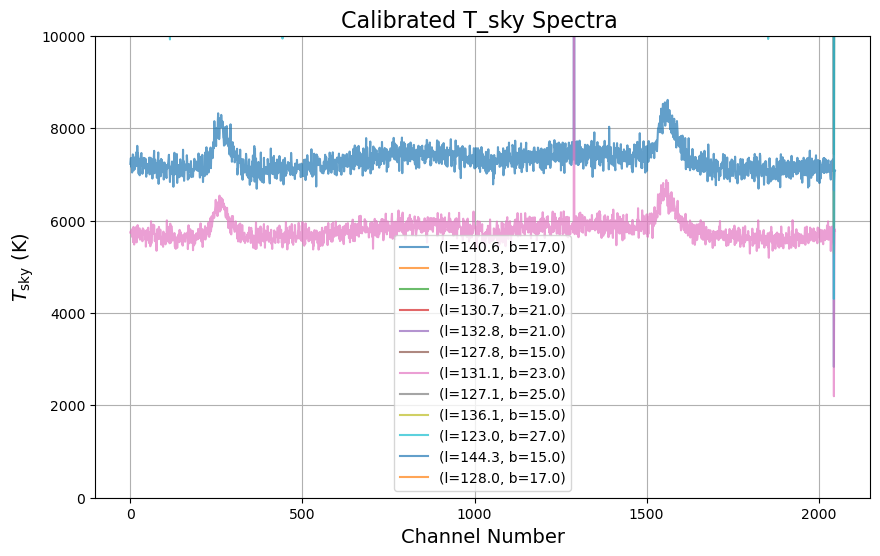

In [99]:
def plot_calibrated_tsky(data_dict, points_to_plot, velocity_axis=None, xlim=None, ylim=None, title_extra=""):
    """
    Plot calibrated T_sky line shapes for given (l, b) points.

    Parameters:
    - data_dict: dict mapping (l, b) -> calibrated temperature array
    - points_to_plot: list of (l, b) tuples to plot
    - velocity_axis: np.ndarray of same length as line shapes, if you want to plot vs velocity (km/s)
    - xlim, ylim: optional x and y axis limits
    - title_extra: str, extra title text
    """
    plt.figure(figsize=(10, 6))

    for l_b in points_to_plot:
        if l_b not in data_dict:
            print(f"Warning: (l, b) = {l_b} not found in data.")
            continue
        
        spectrum = data_dict[l_b]
        label = f"(l={l_b[0]:.1f}, b={l_b[1]:.1f})"
        
        if velocity_axis is not None:
            plt.plot(velocity_axis[:-10], spectrum[:-10], label=label, alpha=0.7)
            plt.xlabel("Velocity (km/s)", fontsize=14)
        else:
            plt.plot(spectrum, label=label, alpha=0.7)
            plt.xlabel("Channel Number", fontsize=14)

    plt.ylabel(r"$T_{\rm sky}$ (K)", fontsize=14)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title(f"Calibrated T_sky Spectra {title_extra}", fontsize=16)
    plt.legend(fontsize=10)
    plt.grid()
    plt.show()

points_to_plot = []
for l, b in T_sky.keys():
    invalid = [(136.371, 17.0), (124.554, 23.0), (122.138, 21)]
    print(l, b)
    if (l, b) not in invalid:
        points_to_plot.append((l, b))
        print("included")

plot_calibrated_tsky(T_sky, points_to_plot, ylim=(0, 10000))

## TO DO
- Compute Gain and calibrate spectra
- Low poly fit on calibrated spectra?
- Gaussian fits on Doppler velocity
- Column density and mass calculation
- Map projection plotting